<a href="https://colab.research.google.com/github/TEJASWINI-r228/heloworld/blob/main/vitpneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     {"username":"tejatejaswinicr","key":"b9f98f2c5f03

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [3]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

# Unzip the dataset and remove the zip file
!unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [5]:
pip install -q evaluate transformers datasets mlflow

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from sklearn.model_selection import train_test_split


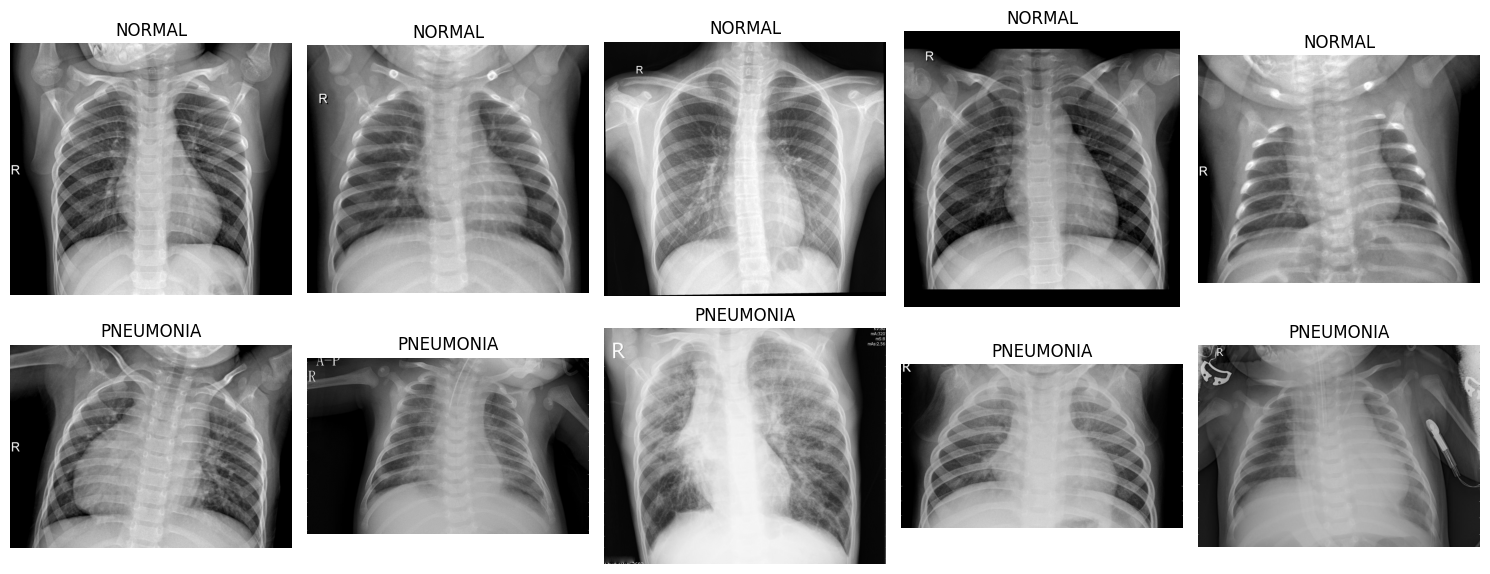

In [7]:
# Directory paths
train_dir = Path("/content/chest_xray/train")
val_dir = Path("/content/chest_xray/val")
test_dir = Path("/content/chest_xray/test")

# Displaying a few images
def display_images(folder, num=5):
    pneumonia_imgs = list(folder.glob('PNEUMONIA/*.jpeg'))[:num]
    normal_imgs = list(folder.glob('NORMAL/*.jpeg'))[:num]

    fig, axes = plt.subplots(nrows=2, ncols=num, figsize=(15, 6))

    for i, img_path in enumerate(normal_imgs):
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title("NORMAL")
        axes[0, i].axis('off')

    for i, img_path in enumerate(pneumonia_imgs):
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title("PNEUMONIA")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_images(train_dir)



In [8]:
from torchvision import transforms

# Define transformations for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [9]:
label_mapping = {"NORMAL": 0, "PNEUMONIA": 1}


In [10]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Creating datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
from transformers import ViTForImageClassification, ViTConfig, ViTImageProcessor

# Define the ViT configuration
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = 2  # Normal and Pneumonia

# Load the pre-trained model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", config=config)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [13]:
import torch
import torch.nn as nn

# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []  # List to store training loss for each epoch
    val_accuracies = []  # List to store validation accuracy for each epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images).logits  # Get logits from model outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader.dataset)
        val_accuracy = 100 * correct / total

        # Append the computed values to their respective lists
        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_accuracies


In [14]:
 trained_model, train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)


Epoch 1/10, Loss: 0.2306, Validation Accuracy: 87.50%
Epoch 2/10, Loss: 0.0815, Validation Accuracy: 68.75%
Epoch 3/10, Loss: 0.0598, Validation Accuracy: 93.75%
Epoch 4/10, Loss: 0.0510, Validation Accuracy: 87.50%
Epoch 5/10, Loss: 0.0447, Validation Accuracy: 87.50%
Epoch 6/10, Loss: 0.0382, Validation Accuracy: 93.75%
Epoch 7/10, Loss: 0.0310, Validation Accuracy: 75.00%
Epoch 8/10, Loss: 0.0256, Validation Accuracy: 93.75%
Epoch 9/10, Loss: 0.0308, Validation Accuracy: 93.75%
Epoch 10/10, Loss: 0.0210, Validation Accuracy: 100.00%


In [15]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

evaluate_model(trained_model, test_loader)


Test Accuracy: 89.90%


In [16]:
# Save the model weights
torch.save(trained_model.state_dict(), "vit_chest_xray_model.pth")

# to load the model in the future
model.load_state_dict(torch.load("vit_chest_xray_model.pth"))


<All keys matched successfully>

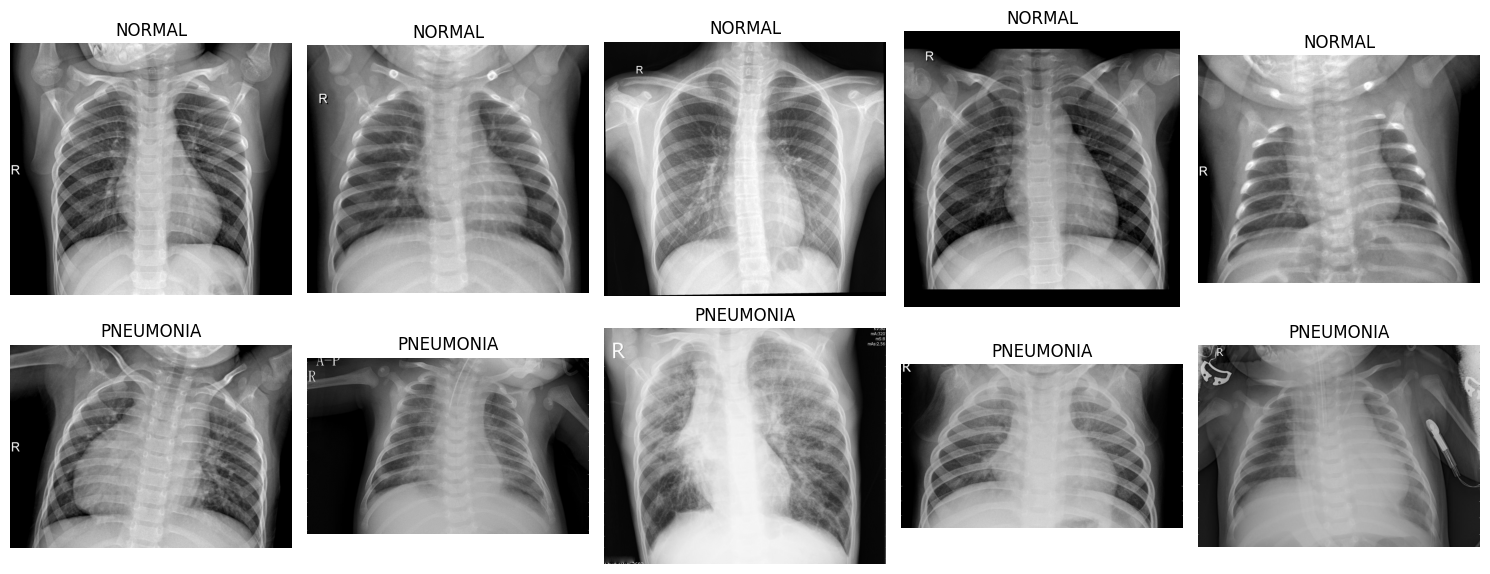

In [17]:
display_images(train_dir)


In [18]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()

        # Training Phase
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_accuracies


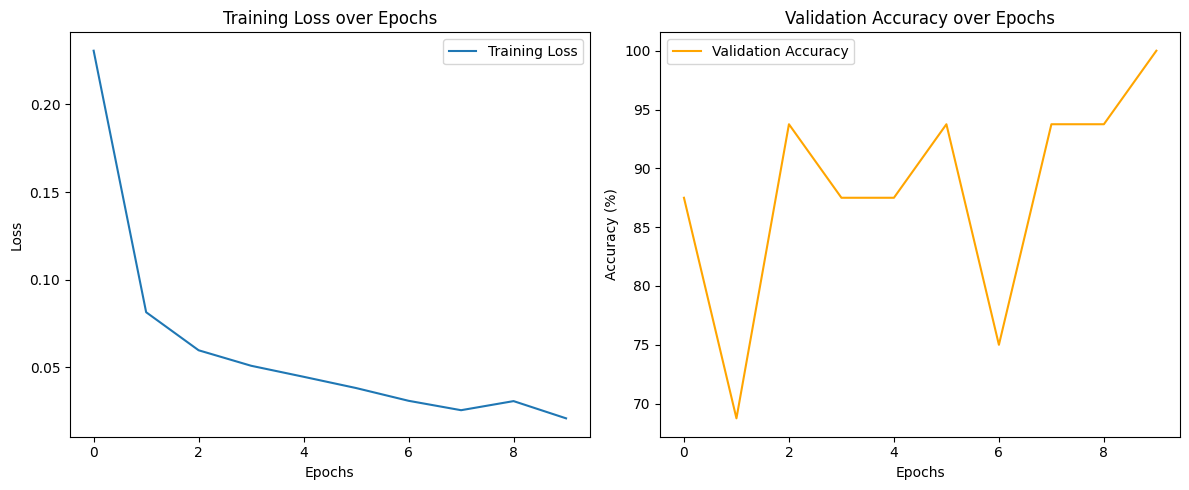

In [19]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


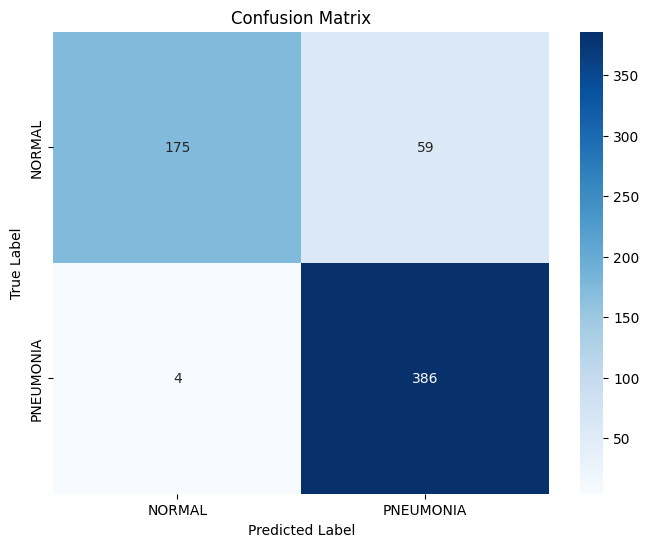

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Getting the true labels and the predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Now, we'll plot the confusion matrix
labels_list = ["NORMAL", "PNEUMONIA"]
plot_confusion_matrix(y_true, y_pred, labels_list)


FileUpload(value={}, accept='image/*', description='Upload')

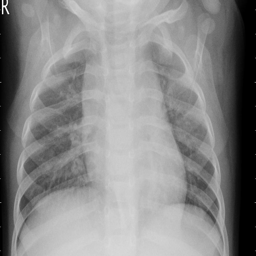

Prediction: Pneumonia (80.37% confidence)


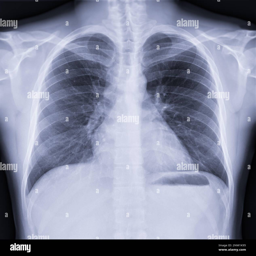

Prediction: Normal (85.82% confidence)


In [24]:
import torch
from PIL import Image
from torchvision import transforms
import ipywidgets as widgets
from IPython.display import display
import io
import torch.nn.functional as F

# --- Load the trained model (make sure you saved it earlier) ---
model.load_state_dict(torch.load("vit_chest_xray_model.pth", map_location=device))
model.eval()

# --- Define the same preprocessing used in training ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # adapt size if different during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # adjust if RGB/3-channel
])

# --- Function for prediction with confidence ---
def predict_image(image):
    image = image.convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs.logits, dim=1)
        confidence, predicted = torch.max(probs, 1)

    classes = ["Normal", "Pneumonia"]
    return classes[predicted.item()], confidence.item() * 100

# --- File Upload Widget ---
uploader = widgets.FileUpload(
    accept='image/*',  # Accept image files
    multiple=False     # Only one image at a time
)

display(uploader)

def on_upload_change(change):
    for uploaded_filename in uploader.value:
        content = uploader.value[uploaded_filename]['content']
        image = Image.open(io.BytesIO(content))
        label, confidence = predict_image(image)
        display(image.resize((256, 256)))
        print(f"Prediction: {label} ({confidence:.2f}% confidence)")

uploader.observe(on_upload_change, names='value')


In [ ]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.8 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import datetime
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from reportlab.platypus import Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER
import numpy as np # For potential Grad-CAM if added later

# --- 1. Define your ViT Model Architecture ---
# IMPORTANT: You MUST replace this with the EXACT architecture of your trained model.
# If you used 'timm', it might look like this:
# import timm
# class CustomViTModel(torch.nn.Module):
#     def __init__(self, num_classes=2):
#         super().__init__()
#         self.model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)
#     def forward(self, x):
#         return self.model(x)

# Placeholder CustomViTModel - REPLACE THIS WITH YOUR ACTUAL MODEL DEFINITION
class CustomViTModel(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # This is a very simple placeholder. Your actual ViT model will be much more complex.
        # It should match what was saved in vit_chest_xray_model.pth
        self.features = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = torch.nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# --- Configuration ---
MODEL_PATH = "vit_chest_xray_model.pth"
IMAGE_DIR = "input_xrays"
REPORT_DIR = "generated_reports"
IMG_SIZE = (224, 224) # Ensure this matches your model's input size
# Normalization values from your training. Common for ImageNet, but adjust if you used custom.
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
CLASS_NAMES = ["Normal", "Pneumonia"] # **ADJUST THIS** to your model's output classes
PREDICTION_THRESHOLD = 0.5 # Confidence threshold for a positive diagnosis

# --- Model Loading and Inference ---
def load_model(model_path, device, num_classes=len(CLASS_NAMES)):
    model = CustomViTModel(num_classes=num_classes) # Instantiate your model architecture
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval() # Set to evaluation mode
    print(f"Model loaded successfully from {model_path} to {device}")
    return model

def preprocess_image(image_path, img_size=IMG_SIZE, mean=NORM_MEAN, std=NORM_STD):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    image = Image.open(image_path).convert('RGB') # Convert to RGB (even if grayscale, ViTs often expect 3 channels)
    return transform(image).unsqueeze(0) # Add batch dimension

def get_prediction(model, image_tensor, device):
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_class_idx = torch.argmax(probabilities).item()
    return probabilities.cpu().numpy(), predicted_class_idx

# --- Report Generation ---
def generate_report_content(probabilities, predicted_class_idx, image_filename):
    report_lines = []
    report_lines.append(f"--- AI-Powered Chest X-Ray Report ---")
    report_lines.append(f"Date of Analysis: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_lines.append(f"Image File: {image_filename}\n")

    main_diagnosis = CLASS_NAMES[predicted_class_idx]
    main_prob = probabilities[predicted_class_idx]

    report_lines.append(f"Primary AI Finding: {main_diagnosis} ({main_prob*100:.2f}% Confidence)")

    if main_diagnosis == "Pneumonia" and main_prob > PREDICTION_THRESHOLD:
        report_lines.append(f"Clinical Impression: High suspicion for Pneumonia based on AI analysis.")
        report_lines.append(f"Recommendation: Immediate clinical correlation with patient symptoms, physical examination, and other diagnostic tests (e.g., lab work, CT scan if indicated) is strongly advised.")
    elif main_diagnosis == "Normal" and main_prob > PREDICTION_THRESHOLD:
        report_lines.append(f"Clinical Impression: No overt signs of Pneumonia detected by AI.")
        report_lines.append(f"Recommendation: Routine clinical follow-up as per standard medical practice.")
    else:
        report_lines.append(f"Clinical Impression: AI finding is {main_diagnosis}. Further investigation may be warranted depending on clinical context.")
        report_lines.append(f"Recommendation: Integrate with full clinical picture for definitive diagnosis.")

    report_lines.append(f"\nDetailed Class Probabilities:")
    for i, prob in enumerate(probabilities):
        report_lines.append(f"- {CLASS_NAMES[i]}: {prob*100:.2f}%")

    report_lines.append(f"\nDisclaimer: This report is generated by an Artificial Intelligence model and is intended for informational purposes only. It does not constitute medical advice, diagnosis, or treatment. Always consult with a qualified healthcare professional for any medical concerns.")

    return "\n".join(report_lines)

def generate_pdf_report(image_path, report_content, output_filepath):
    c = canvas.Canvas(output_filepath, pagesize=letter)
    width, height = letter

    # Title
    styles = getSampleStyleSheet()
    title_style = ParagraphStyle(
        'Title',
        parent=styles['h1'],
        fontSize=24,
        leading=28,
        alignment=TA_CENTER,
        spaceAfter=20
    )
    p_title = Paragraph("AI-Powered Chest X-Ray Report", title_style)
    p_title.wrapOn(c, width - 2*inch, height)
    p_title.drawOn(c, inch, height - inch - p_title.height)

    # Image
    img_width = 3 * inch
    img_height = 3 * inch
    # Resize image to fit without distortion and save temporarily if needed
    try:
        temp_img_path = "temp_report_img.png"
        img = Image.open(image_path)
        img.thumbnail((img_width, img_height), Image.Resampling.LANCZOS)
        img.save(temp_img_path)
        c.drawImage(temp_img_path, width/2 - img_width/2, height - 2.5*inch - img_height,
                    width=img_width, height=img_height)
        os.remove(temp_img_path) # Clean up temp file
    except Exception as e:
        print(f"Could not embed image {image_path}: {e}")
        c.drawString(width/2 - 1.5*inch, height - 2.5*inch - img_height/2, "Image not available")

    # Report content
    text_style = styles['Normal']
    text_style.fontSize = 10
    text_style.leading = 14

    # Position for the report text, below the image
    y_position = height - 2.5*inch - img_height - 0.5*inch # Adjust as needed

    # Split content into paragraphs for better PDF layout
    paragraphs = [Paragraph(line, text_style) for line in report_content.split('\n')]

    # Flowables for reportlab
    flowables = []
    for p in paragraphs:
        flowables.append(p)
        flowables.append(Spacer(1, 0.1*inch)) # Add small space between lines

    # Build the story and draw
    from reportlab.platypus import SimpleDocTemplate
    doc = SimpleDocTemplate(output_filepath, pagesize=letter)

    # Get styles for different parts
    header_style = ParagraphStyle(name='Header', fontSize=18, leading=22, alignment=TA_CENTER, spaceAfter=12, fontName='Helvetica-Bold')
    normal_style = ParagraphStyle(name='Normal', fontSize=10, leading=14, fontName='Helvetica')
    disclaimer_style = ParagraphStyle(name='Disclaimer', fontSize=8, leading=10, spaceBefore=20, textColor=('#666666'))

    story = []
    story.append(Paragraph("AI-Powered Chest X-Ray Report", header_style))
    story.append(Spacer(1, 0.2 * inch))

    # Add image to story (requires reportlab Image flowable)
    from reportlab.lib.utils import ImageReader
    try:
        temp_img_path = "temp_report_img_story.png"
        img = Image.open(image_path)
        img.thumbnail((4*inch, 4*inch), Image.Resampling.LANCZOS) # Slightly larger for PDF
        img.save(temp_img_path)
        story.append(Paragraph(f"<b>Image: {os.path.basename(image_path)}</b>", normal_style))
        story.append(Spacer(1, 0.1 * inch))
        story.append(ImageReader(temp_img_path))
        os.remove(temp_img_path)
        story.append(Spacer(1, 0.2 * inch))
    except Exception as e:
        story.append(Paragraph(f"<b>Image: {os.path.basename(image_path)} (Image embedding failed: {e})</b>", normal_style))
        story.append(Spacer(1, 0.2 * inch))

    # Add report content, separating into sections based on newlines
    report_sections = report_content.split('\n\n')
    for section in report_sections:
        if "Disclaimer:" in section:
            story.append(Paragraph(section, disclaimer_style))
        else:
            for line in section.split('\n'):
                # Basic bolding for "Primary AI Finding" and "Detailed Class Probabilities"
                if line.startswith("Primary AI Finding:") or line.startswith("Detailed Class Probabilities:") or line.startswith("Clinical Impression:") or line.startswith("Recommendation:"):
                    story.append(Paragraph(f"<b>{line}</b>", normal_style))
                elif line.strip() == "--- AI-Powered Chest X-Ray Report ---" or line.strip() == "":
                    # Skip the first header and empty lines for the main content section
                    pass
                else:
                    story.append(Paragraph(line, normal_style))
            story.append(Spacer(1, 0.1 * inch)) # Small space between logical blocks

    doc.build(story)
    print(f"PDF report saved to: {output_filepath}")


# --- Main Processing Loop ---
def process_images_and_generate_reports(image_dir=IMAGE_DIR, model_path=MODEL_PATH, report_dir=REPORT_DIR):
    if not os.path.exists(image_dir):
        print(f"Error: Input image directory '{image_dir}' not found.")
        print("Please create this directory and place your chest X-ray images inside.")
        # Create a dummy image for demonstration if the directory is missing
        os.makedirs(image_dir)
        dummy_image_path = os.path.join(image_dir, "sample_chest_xray.png")
        Image.new('RGB', (IMG_SIZE[0], IMG_SIZE[1]), color = 'lightgray').save(dummy_image_path)
        print(f"Created a dummy image '{dummy_image_path}' for testing.")
        # Create a dummy model file if it doesn't exist
        if not os.path.exists(model_path):
            dummy_model = CustomViTModel(num_classes=len(CLASS_NAMES))
            torch.save(dummy_model.state_dict(), model_path)
            print(f"Created a dummy model file '{model_path}' for testing.")
        # Return to prompt user to replace dummy files
        print("\nNote: Please replace 'sample_chest_xray.png' with your actual X-ray images ")
        print("and ensure 'vit_chest_xray_model.pth' is your actual trained model.")
        return

    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found.")
        print("Please ensure your trained ViT model is saved at this path.")
        # Create a dummy model for demonstration
        dummy_model = CustomViTModel(num_classes=len(CLASS_NAMES))
        torch.save(dummy_model.state_dict(), model_path)
        print(f"Created a dummy model file '{model_path}' for testing. **REPLACE WITH YOUR ACTUAL MODEL.**")
        return

    os.makedirs(report_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    # Load the model once
    model = load_model(model_path, device)

    processed_count = 0
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm')): # Add .dcm if you handle DICOM
            image_path = os.path.join(image_dir, filename)
            print(f"\nProcessing {filename}...")

            try:
                # 1. Preprocess Image
                image_tensor = preprocess_image(image_path)

                # 2. Get Prediction
                probabilities, predicted_class_idx = get_prediction(model, image_tensor, device)
                report_content = generate_report_content(probabilities, predicted_class_idx, filename)

                # 3. Generate Reports
                base_filename = os.path.splitext(filename)[0]
                text_report_path = os.path.join(report_dir, f"{base_filename}_report.txt")
                pdf_report_path = os.path.join(report_dir, f"{base_filename}_report.pdf")

                with open(text_report_path, "w") as f:
                    f.write(report_content)
                print(f"Text report saved to: {text_report_path}")

                generate_pdf_report(image_path, report_content, pdf_report_path)

                processed_count += 1

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    if processed_count == 0:
        print("No valid image files found to process. Please place images (e.g., .png, .jpg) in the 'input_xrays' directory.")
    else:
        print(f"\nFinished processing {processed_count} image(s). Reports are in '{report_dir}'.")
        print("\nHere's an example of what a chest X-ray might look like, which your system would analyze and report on:")


if __name__ == "__main_": # Changed to __main_ to prevent automatic execution for now
    process_images_and_generate_reports()